In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
sst_normed = np.load('../CESM_data/CESM_SST_normalized.npy').astype(np.float32)
sss_normed = np.load('../CESM_data/CESM_SSS_normalized.npy').astype(np.float32)

In [3]:
lead = 12
tstep = 1032
channels = 2

In [4]:
y = np.mean(sst_normed[:,lead:,:,:],axis=(2,3)).reshape((tstep-lead)*42,1)  
X = np.transpose(
    np.array([sst_normed,sss_normed])[:,:,0:tstep-lead,:,:].reshape(channels,(tstep-lead)*42,33,89),
    (1,0,2,3))

In [5]:
percent_train = 0.8

X_train = torch.from_numpy( X[0:int(np.floor(percent_train*(tstep-lead)*42)),:,:,:] )
y_train = torch.from_numpy( y[0:int(np.floor(percent_train*(tstep-lead)*42)),:] )

X_val = torch.from_numpy( X[int(np.floor(percent_train*(tstep-lead)*42)):,:,:,:] )
y_val = torch.from_numpy( y[int(np.floor(percent_train*(tstep-lead)*42)):,:] )

In [6]:
max_epochs = 50
batch_size = 64

In [7]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)

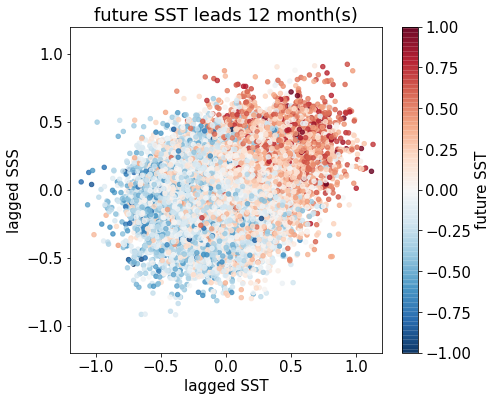

In [8]:
plt.figure(figsize=(7,6))
plt.rcParams.update({'font.size': 15})

sc = plt.scatter(np.mean(X_train[:,0,:,:].numpy(),axis=(1,2)),
                 np.mean(X_train[:,1,:,:].numpy(),axis=(1,2)),
                 c=y_train.numpy(),vmin=-1,vmax=1,cmap='RdBu_r',s=20,alpha=0.8)

plt.colorbar(sc,label='future SST')
plt.ylim([-1.2,1.2])
plt.xlim([-1.2,1.2])
plt.xlabel('lagged SST')
plt.ylabel('lagged SSS')
plt.title('future SST leads '+str(lead)+' month(s)')
plt.show()

In [9]:
model = nn.Sequential(nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=5),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=5),
                      
          nn.Flatten(),
          nn.Linear(in_features=5*17*32,out_features=128),
          nn.ReLU(),
          nn.Linear(in_features=128,out_features=64),
          nn.ReLU(),
          
          nn.Dropout(p=0.5),
          nn.Linear(in_features=64,out_features=1))

opt = torch.optim.Adadelta(model.parameters())
loss_fn = nn.MSELoss()

In [10]:
epo_train_losses = []
epo_val_losses = []

for iepoch in tqdm(range(max_epochs)):
    
    batch_train_losses = []
    model.train()
    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch)
        loss = loss_fn(y_pred.squeeze(), y_batch.squeeze())
        batch_train_losses.append(loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
    epo_train_losses.append( sum(batch_train_losses)/len(batch_train_losses) )

    batch_val_losses = []
    with torch.set_grad_enabled(False):
        for x_batch_val, y_batch_val in val_loader:
            y_pred = model(x_batch_val)
            loss = loss_fn(y_pred.squeeze(), y_batch_val.squeeze())
            batch_val_losses.append(loss.item())
        epo_val_losses.append( sum(batch_val_losses)/len(batch_val_losses) )

  0%|          | 0/50 [00:00<?, ?it/s]/disk7/pdwang/miniconda3/envs/ml_env/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(
100%|██████████| 50/50 [18:29<00:00, 22.19s/it]


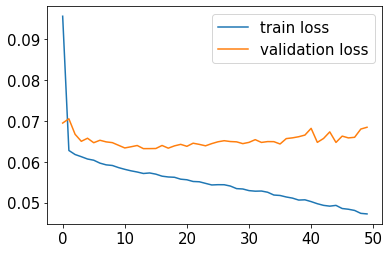

In [11]:
plt.plot(epo_train_losses)
plt.plot(epo_val_losses)
plt.legend(['train loss','validation loss'])
plt.show()

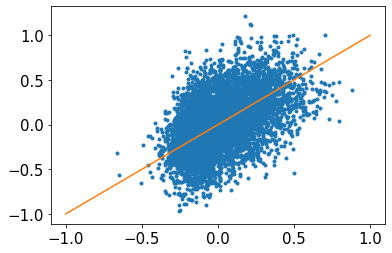

In [12]:
model.eval()
plt.plot( model(X_val).detach().numpy(),y_val.detach().numpy(),'.' )
plt.plot( [-1,1],[-1,1] )

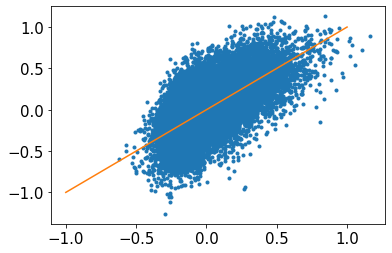

In [13]:
model.eval()
plt.plot( model(X_train).detach().numpy(),y_train.detach().numpy(),'.' )
plt.plot( [-1,1],[-1,1] )